# Populating missing values- Basic Emotions

The following section evaluates the optimal approach to populating data with regards to basic emotional theory. The EmoTag1200 dataset contains information regarding the 150 most common emojis, however this is much less data than what is available for dimensional theory. EDA has highlighted patterns which can correlate the basic and dimensional model data so its use in prediction is likely to be helpful.

Present works in the field use a range of prediction methodologies which heavily rely on association to some word centric corpus to predict emoji sentiment with varying suitability for use in the context of this work. Most common methods rely on associations with words adjacent to the emojis within the content under evaluation which is fundamentally contradictory to the hypothesis in question for this work overall (there is evidence that incongruence in emoji and adjacent word sentiment can indicate sarcasm, this work aims to exploit this to improve outcomes for sarcasm prediction) and thus any methodologies which fall into this category will be omitted from consideration.

# Data cleaning and preparation

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
#Importing data
df = pd.read_csv("Combined_Emot_Data.csv")

#Create a column that adds the total values for all basic emotions
df['total'] = df['anger'] + df['anticipation'] + df['disgust'] + df['fear'] + df['joy'] + df['sadness'] + df['surprise'] + df['trust']

#Create a list of basic emotions
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

In [4]:
#Creation of datasets using selected best smoothing method- Laplace Estimator
df_le01 = df.copy()
for emotion in emotions:
    df_le01[emotion] = (df_le01[emotion] + 0.1) / (df_le01["total"])

In [5]:
#Check for null values
df.isnull().sum()

unicode               0
emoji                 0
anger                 0
anticipation          0
disgust               0
fear                  0
joy                   0
sadness               0
surprise              0
trust                 0
Position              0
Unicode block         0
le_+                  0
le_-                  0
le_0                  0
sent_score            0
sent_score_class      0
upper_error_class     0
lower_error_class     0
sent_polar            0
primary_basic_emot    0
total                 0
dtype: int64

In [6]:
df_le01.shape

(149, 22)

# Preparation of data for machine learning- Feature Scaling

Scaling is a challenge in the context of this problem set. Due to the nature of emotions, it may not be desirable to scale data within the subclasses of basic and dimensional theory in line with the overall dataset as the greater and lesser relavtive values of each emotion are reflective of the strength of the emotion which is associated with the emoji itself. This is additional relevant and important information which should be retained. However this is not to say that the two models data is appropriately scaled for optimal compatability at present. The following section aims to evaluate if feature scaling for numeric values is necessary, and if so, the optimal method to do so.

In [7]:
#Check for columns containing numerical data
df_le01.dtypes
#They fall into three classes- basic and dimensional model data and position of emoji in text

unicode                object
emoji                  object
anger                 float64
anticipation          float64
disgust               float64
fear                  float64
joy                   float64
sadness               float64
surprise              float64
trust                 float64
Position              float64
Unicode block          object
le_+                  float64
le_-                  float64
le_0                  float64
sent_score            float64
sent_score_class       object
upper_error_class      object
lower_error_class      object
sent_polar             object
primary_basic_emot     object
total                 float64
dtype: object

In [8]:
#Check means
df_le01['total'].mean(), df_le01['sent_score'].mean(), df_le01['le_0'].mean()

(1.5528859060402684, 0.32754414318448444, 0.317953718703662)

In [9]:
#Check medians
df_le01['total'].median(), df_le01['sent_score'].median(), df_le01['le_0'].median()

(1.6100000000000003, 0.4169909208819715, 0.2786885245901639)

In [10]:
#Check ranges
df_le01.describe()

anger  anticipation     disgust        fear         joy  \
count  149.000000    149.000000  149.000000  149.000000  149.000000   
mean     0.154453      0.296006    0.164143    0.159612    0.326227   
std      0.134433      0.187403    0.138884    0.125805    0.211109   
min      0.043290      0.075630    0.043290    0.043290    0.033898   
25%      0.066667      0.188406    0.068966    0.080000    0.118644   
50%      0.112360      0.248731    0.123288    0.120482    0.357143   
75%      0.183908      0.344371    0.213953    0.203209    0.476636   
max      0.909091      1.636364    0.909091    0.909091    1.181818   

          sadness    surprise       trust    Position        le_+        le_-  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   
mean     0.164158    0.196485    0.275838    0.748170    0.504795    0.177251   
std      0.136795    0.117012    0.188641    0.117897    0.171828    0.165133   
min      0.043290    0.040816    0.048544    0.193496    0.123188    0.008403   
25%      0.071942    0.125749    0.139073    0.701409    0.359684    0.052632   
50%      0.116279    0.175115    0.256757    0.779044    0.526316    0.107143   
75%      0.207207    0.238095    0.351598    0.827467    0.633523    0.264642   
max      0.909091    0.909091    1.285714    0.919654    0.798969    0.600583   

             le_0  sent_score       total  
count  149.000000  149.000000  149.000000  
mean     0.317954    0.327544    1.552886  
std      0.140179    0.306492    0.622342  
min      0.108037   -0.396501    0.110000  
25%      0.221106    0.125984    1.160000  
50%      0.278689    0.416991    1.610000  
75%      0.367089    0.559311    1.970000  
max      0.855072    0.778351    3.150000

Proposed scaling methodology (Basic theory data): There are three primary numeric parameter categories for emotion sentiment in this dataset; 'total'- sum of all affinities to the basic emotion categories, 'sent_score'- polar score based on a positive/negative scale from the dimensional model and 'le_0'- value from dimensional model which represents degree of arousal with regards to a particular emotion. 'Total' and 'sent_score' are each made up of the cumulation of values from other columns and thus are a good manner in which to normalise influence of values across the two models. These parameters will be scaled and the parameters which they are comprised of will be rescaled based on the scaled values within their row rather than with consideration to any other row. For example where the core parameters were rescaled from 0 to 1 using a min-max scaler (normalisation) and emoji X has a 'total' value which is scaled to 0.8 and it had a 50% affinity to anger the value associated with anger would be 0.4 rather than 0.5.

Note that the purpose of this methods it to address the observation that it is not necessarily valid to normalise the components of these core parameters as this would result in bias in many cases. For example note that anger and anticipation have ranges of 0-1 and 0-0.81 respectively. Where min-max scaling is applied to these parameters without consideration to each other there would be an increase in the perception of affinify to the emotion of anticipation where it is not the case in reality. The proposed method aims to avoid this.

In [11]:
#Add another column for dimensional theory processing- sum of +ve and -ve sentiment scores
df_le01['dt_total_prescale'] = df_le01['le_+'] + df_le01['le_-']

In [12]:
#Define columns to be scaled
scale_cols=['total', 'sent_score', 'le_0', 'Position']

#Apply min max scaler to relevant columns
def scaling(df_le01):
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    df_le01[scale_cols]=scaler.fit_transform(df_le01[scale_cols])
    return df_le01

df_le01 = scaling(df_le01)

In [13]:
#Verify it worked
df_le01.describe()

anger  anticipation     disgust        fear         joy  \
count  149.000000    149.000000  149.000000  149.000000  149.000000   
mean     0.154453      0.296006    0.164143    0.159612    0.326227   
std      0.134433      0.187403    0.138884    0.125805    0.211109   
min      0.043290      0.075630    0.043290    0.043290    0.033898   
25%      0.066667      0.188406    0.068966    0.080000    0.118644   
50%      0.112360      0.248731    0.123288    0.120482    0.357143   
75%      0.183908      0.344371    0.213953    0.203209    0.476636   
max      0.909091      1.636364    0.909091    0.909091    1.181818   

          sadness    surprise       trust    Position        le_+        le_-  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   
mean     0.164158    0.196485    0.275838    0.766209    0.504795    0.177251   
std      0.136795    0.117012    0.188641    0.160733    0.171828    0.165133   
min      0.043290    0.040816    0.048544    0.010000    0.123188    0.008403   
25%      0.071942    0.125749    0.139073    0.702458    0.359684    0.052632   
50%      0.116279    0.175115    0.256757    0.808300    0.526316    0.107143   
75%      0.207207    0.238095    0.351598    0.874317    0.633523    0.264642   
max      0.909091    0.909091    1.285714    1.000000    0.798969    0.600583   

             le_0  sent_score       total  dt_total_prescale  
count  149.000000  149.000000  149.000000         149.000000  
mean     0.288190    0.620124    0.479887           0.682046  
std      0.185770    0.258268    0.202671           0.140179  
min      0.010000    0.010000    0.010000           0.144928  
25%      0.159843    0.450277    0.351941           0.632911  
50%      0.236154    0.695497    0.498487           0.721311  
75%      0.353305    0.815424    0.615724           0.778894  
max      1.000000    1.000000    1.000000           0.891963

In [14]:
#Scale all data for basic emotions based on their scaled values from the total column

#Re-Create a column that contains the sum of all basic emotion values
df_le01['total_prescale'] = df_le01['anger'] + df_le01['anticipation'] + df_le01['disgust'] + df_le01['fear'] + df_le01['joy'] + df_le01['sadness'] + df_le01['surprise'] + df_le01['trust']

#Determine scaling factor for the row
df_le01['scaling_factor'] = df_le01['total_prescale']/df_le01['total']

#Scale each basic emotion value using the scaling factor
df_le01['anger'] = df_le01['anger']/df_le01['scaling_factor']
df_le01['anticipation'] = df_le01['anticipation']/df_le01['scaling_factor']
df_le01['disgust'] = df_le01['disgust']/df_le01['scaling_factor']
df_le01['fear'] = df_le01['fear']/df_le01['scaling_factor']
df_le01['joy'] = df_le01['joy']/df_le01['scaling_factor']
df_le01['sadness'] = df_le01['sadness']/df_le01['scaling_factor']
df_le01['surprise'] = df_le01['surprise']/df_le01['scaling_factor']
df_le01['trust'] = df_le01['trust']/df_le01['scaling_factor']

In [15]:
#Verify this worked
df_le01.describe()

anger  anticipation     disgust        fear         joy  \
count  149.000000    149.000000  149.000000  149.000000  149.000000   
mean     0.042490      0.076001    0.047440    0.047364    0.090365   
std      0.042791      0.035287    0.046072    0.048874    0.070341   
min      0.001099      0.001978    0.001099    0.001099    0.001429   
25%      0.019370      0.051549    0.019309    0.019370    0.024484   
50%      0.022793      0.073606    0.022623    0.026510    0.070020   
75%      0.047478      0.100284    0.057727    0.054324    0.149256   
max      0.257910      0.215172    0.185523    0.266749    0.256943   

          sadness    surprise       trust    Position        le_+        le_-  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   
mean     0.049037    0.055693    0.071498    0.766209    0.504795    0.177251   
std      0.055080    0.036799    0.046182    0.160733    0.171828    0.165133   
min      0.001099    0.001099    0.001099    0.010000    0.123188    0.008403   
25%      0.019782    0.029197    0.039906    0.702458    0.359684    0.052632   
50%      0.023358    0.049237    0.058336    0.808300    0.526316    0.107143   
75%      0.047865    0.073565    0.095147    0.874317    0.633523    0.264642   
max      0.259172    0.223153    0.216957    1.000000    0.798969    0.600583   

             le_0  sent_score       total  dt_total_prescale  total_prescale  \
count  149.000000  149.000000  149.000000         149.000000      149.000000   
mean     0.288190    0.620124    0.479887           0.682046        1.736922   
std      0.185770    0.258268    0.202671           0.140179        0.837552   
min      0.010000    0.010000    0.010000           0.144928        1.253968   
25%      0.159843    0.450277    0.351941           0.632911        1.406091   
50%      0.236154    0.695497    0.498487           0.721311        1.496894   
75%      0.353305    0.815424    0.615724           0.778894        1.689655   
max      1.000000    1.000000    1.000000           0.891963        8.272727   

       scaling_factor  
count      149.000000  
mean        13.748058  
std         73.215495  
min          1.253968  
25%          2.283640  
50%          3.002876  
75%          4.800964  
max        827.272727

In [16]:
#Remove columns that are no longer needed
df_le01 = df_le01.drop(columns=['total_prescale', 'scaling_factor'])

In [17]:
#Repeat similar method for dimensional theory data- only +ve and -ve and necessary

#Re-Create a column that contains the sum of all basic emotion values
df_le01['total'] = df_le01['le_+'] + df_le01['le_-']

#Determine scaling factor for the row
df_le01['scaling_factor'] = df_le01['dt_total_prescale']/df_le01['total']

#Scale each basic emotion value using the scaling factor
df_le01['le_+'] = df_le01['le_+']/df_le01['scaling_factor']

In [18]:
#Remove columns that are no longer needed
df_le01 = df_le01.drop(columns=['dt_total_prescale', 'scaling_factor', 'total'])

In [19]:
#Verify transformations are ok
df_le01.describe()

anger  anticipation     disgust        fear         joy  \
count  149.000000    149.000000  149.000000  149.000000  149.000000   
mean     0.042490      0.076001    0.047440    0.047364    0.090365   
std      0.042791      0.035287    0.046072    0.048874    0.070341   
min      0.001099      0.001978    0.001099    0.001099    0.001429   
25%      0.019370      0.051549    0.019309    0.019370    0.024484   
50%      0.022793      0.073606    0.022623    0.026510    0.070020   
75%      0.047478      0.100284    0.057727    0.054324    0.149256   
max      0.257910      0.215172    0.185523    0.266749    0.256943   

          sadness    surprise       trust    Position        le_+        le_-  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   
mean     0.049037    0.055693    0.071498    0.766209    0.504795    0.177251   
std      0.055080    0.036799    0.046182    0.160733    0.171828    0.165133   
min      0.001099    0.001099    0.001099    0.010000    0.123188    0.008403   
25%      0.019782    0.029197    0.039906    0.702458    0.359684    0.052632   
50%      0.023358    0.049237    0.058336    0.808300    0.526316    0.107143   
75%      0.047865    0.073565    0.095147    0.874317    0.633523    0.264642   
max      0.259172    0.223153    0.216957    1.000000    0.798969    0.600583   

             le_0  sent_score  
count  149.000000  149.000000  
mean     0.288190    0.620124  
std      0.185770    0.258268  
min      0.010000    0.010000  
25%      0.159843    0.450277  
50%      0.236154    0.695497  
75%      0.353305    0.815424  
max      1.000000    1.000000

# Feature scaling-Distributed word vectors based on emotion words

Challenges cited in other work on the topic often relate to the lack of features associated with the emoji itself, making any prediction task challenging. The following section evaluates a range of options for feature extraction which may improve outcomes compared to options where limited features were cited as a challenge.

The following work aims to adapt a method previously proposed by *****. Given any emoji and basic emotion, the method compared the emoji and the basic emotion using their respective vectors. A similarity score based upon the cosine similarity metric will be generated, indicating the strength of association between the pair. The initial selection of cosine similarity score is based upon its frequency in use for similar NLP comparative work, most notably that which this method is adapting. The original work utilized a word embedding for emojis where vectors were generated based upon surrounding vocabulary within text. This approach is largely acceptable for the purposes of this work, with the exception of the word vector to incorporate emojis selected. This vector fails to account for incongruency in emoji sentiment and surrounding text being an indicator of figuratve language, but rather implies all emojis are used in such a manner that their sentiment is consistent with surrounding text. The converse is postulated to be case in this work therefore an alternative word embedding must be selected. Alternative methods for vector comparison will also be explored which may consider other characteristics of the data vectors to determine similarity.

The purpose of generating these values is to expand upon the data that can be gleaned from an emoji in order to make predictions regarding basic emotion affinities for emojis which are unseen in the EmoTag1200 dataset. The most common limitation cited when working with emojis for any form of machine learning is a lack of information contained in it compared to text. This is one such avenue which this work aims to explore to improve upon present state of the art in this regard.

In [20]:
#Importing libraries
from gensim.models import KeyedVectors
import gensim.downloader as api
from nltk import ngrams
from scipy.stats import weightedtau

In [ ]:
#Commented out as this took a long time previously

#Download the pre-trained Word2Vec model from Gensim data server (300d to match emoji vector)
#word2vec_model = api.load('word2vec-google-news-300')

#Define list of basic emotions to extract word vectors
#emotion_words = ['joy', 'anger', 'sadness', 'fear', 'surprise', 'disgust', 'anticipation', 'trust']

#Extract the word vectors for the basic emotions
#emotion_word_vectors = {word: word2vec_model[word] for word in emotion_words if word in word2vec_model}

#Save to a new file for later use
#output_file = 'basic_emot_vectors.txt'

#Get the vector size from the first word vector in the dictionary
#vector_size = len(emotion_word_vectors[list(emotion_word_vectors.keys())[0]])

#with open(output_file, 'w', encoding='utf-8') as file:
    #Write the first line with vocabulary size and vector size
    #file.write(f"{len(emotion_word_vectors)} {vector_size}\n")

    #Write each emotion word and its corresponding vector to the file
    #for word, vector in emotion_word_vectors.items():
        #vector_str = ' '.join(str(val) for val in vector)
        #file.write(f'{word} {vector_str}\n')

In [26]:
#Look at my emoji embedding
emoji2vec = KeyedVectors.load_word2vec_format('emoji2vec.txt', binary=False)

#Get the vocabulary size (number of emojis)
vocab_size = len(emoji2vec.key_to_index)
print("Vocabulary Size:", vocab_size)

#Get the dimensionality of the word embeddings
embedding_dim = emoji2vec.vector_size
print("Embedding Dimension:", embedding_dim)

Vocabulary Size: 1661
Embedding Dimension: 300


In [24]:
#Look at my basic emotion embedding
basic2vec = KeyedVectors.load_word2vec_format('basic_emot_vectors.txt', binary=False)

#Get the vocabulary size (number of words-basic emotions)
vocab_size = len(basic2vec.key_to_index)
print("Vocabulary Size:", vocab_size)

#Get the dimensionality of the word embeddings
embedding_dim = basic2vec.vector_size
print("Embedding Dimension:", embedding_dim)

Vocabulary Size: 8
Embedding Dimension: 300


In [27]:
#Use cosine similarity to compare

#Generate list of basic emotions
emotions = ['anger', 'joy', 'sadness', 'fear', 'surprise', 'disgust', 'anticipation', 'trust']

#Define function to calculate cosine similarity between two vectors
def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

#Loop through each emotion and calculate similarity scores for each emoji
for emotion in emotions:
    #Create a new column for the similarity score of each emoji with respect to the current emotion
    df_le01[f'co_sim_{emotion}'] = df_le01['emoji'].apply(lambda x: cosine_similarity(emoji2vec[x], basic2vec[emotion]) if x in emoji2vec else None)

#Display altered dataset
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar primary_basic_emot  \
0  0.032855  0.065710  0.088298  ...    Positive                joy   
1  0.015419  0.024671  0.053967  ...    Positive       anticipation   
2  0.051856  0.028610  0.037551  ...    Positive                joy   
3  0.019122  0.040157  0.061191  ...    Positive                joy   
4  0.019370  0.067795  0.079417  ...    Positive                joy   

   co_sim_anger  co_sim_joy  co_sim_sadness  co_sim_fear co_sim_surprise  \
0      0.212815    0.398045        0.307879     0.170043        0.168778   
1      0.031860    0.097309        0.137938     0.102546        0.056646   
2      0.112067    0.165191        0.168149     0.186228        0.173427   
3      0.115099    0.183506        0.124933     0.159108        0.077226   
4      0.100389    0.269118        0.175544     0.122721        0.223669   

  co_sim_disgust co_sim_anticipation co_sim_trust  
0       0.276684            0.141978     0.103585  
1       0.071432            0.176522     0.040214  
2       0.126981            0.219476     0.101377  
3       0.162806            0.089916     0.037725  
4       0.129766            0.143079     0.081530  

[5 rows x 29 columns]

In [35]:
#Repeat with euclidian distances

#Define function to calculate Euclidean distance between two vectors
def euclidean_distance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

#Loop through each emotion and calculate similarity scores for each emoji
for emotion in emotions:
    #Create a new column for the similarity score of each emoji with respect to the current emotion
    df_le01[f'euc_dist_{emotion}'] = df_le01['emoji'].apply(lambda x: euclidean_distance(emoji2vec[x], basic2vec[emotion]) if x in emoji2vec else None)

#Display altered dataset
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  co_sim_anticipation co_sim_trust  \
0  0.032855  0.065710  0.088298  ...             0.141978     0.103585   
1  0.015419  0.024671  0.053967  ...             0.176522     0.040214   
2  0.051856  0.028610  0.037551  ...             0.219476     0.101377   
3  0.019122  0.040157  0.061191  ...             0.089916     0.037725   
4  0.019370  0.067795  0.079417  ...             0.143079     0.081530   

   euc_dist_anger  euc_dist_joy  euc_dist_sadness  euc_dist_fear  \
0       22.965086     22.385473         22.605833      23.134501   
1       21.752522     21.534067         21.413471      21.503735   
2       23.236128     23.067062         23.046669      23.032419   
3       19.995880     19.776051         19.974701      19.860977   
4       21.206022     20.669111         20.956097      21.124264   

  euc_dist_surprise euc_dist_disgust euc_dist_anticipation euc_dist_trust  
0         23.141672        22.784658             23.209110      23.310059  
1         21.619774        21.609434             21.309780      21.671391  
2         23.070414        23.186100             22.946081      23.256742  
3         20.072878        19.841698             20.042284      20.184591  
4         20.863853        21.106775             21.071026      21.234791  

[5 rows x 37 columns]

In [29]:
#Create lists to compare basic emotion values here to the similarity scores from word vectors
basic_emotions = ['anger', 'joy', 'sadness', 'fear', 'surprise', 'disgust', 'anticipation', 'trust']
cosine_sim_emotions = ['co_sim_anger', 'co_sim_joy', 'co_sim_sadness', 'co_sim_fear', 'co_sim_surprise',
                      'co_sim_disgust', 'co_sim_anticipation', 'co_sim_trust']
euc_dist_emotions = ['euc_dist_anger', 'euc_dist_joy', 'euc_dist_sadness', 'euc_dist_fear', 'euc_dist_surprise',
                      'euc_dist_disgust', 'euc_dist_anticipation', 'euc_dist_trust']

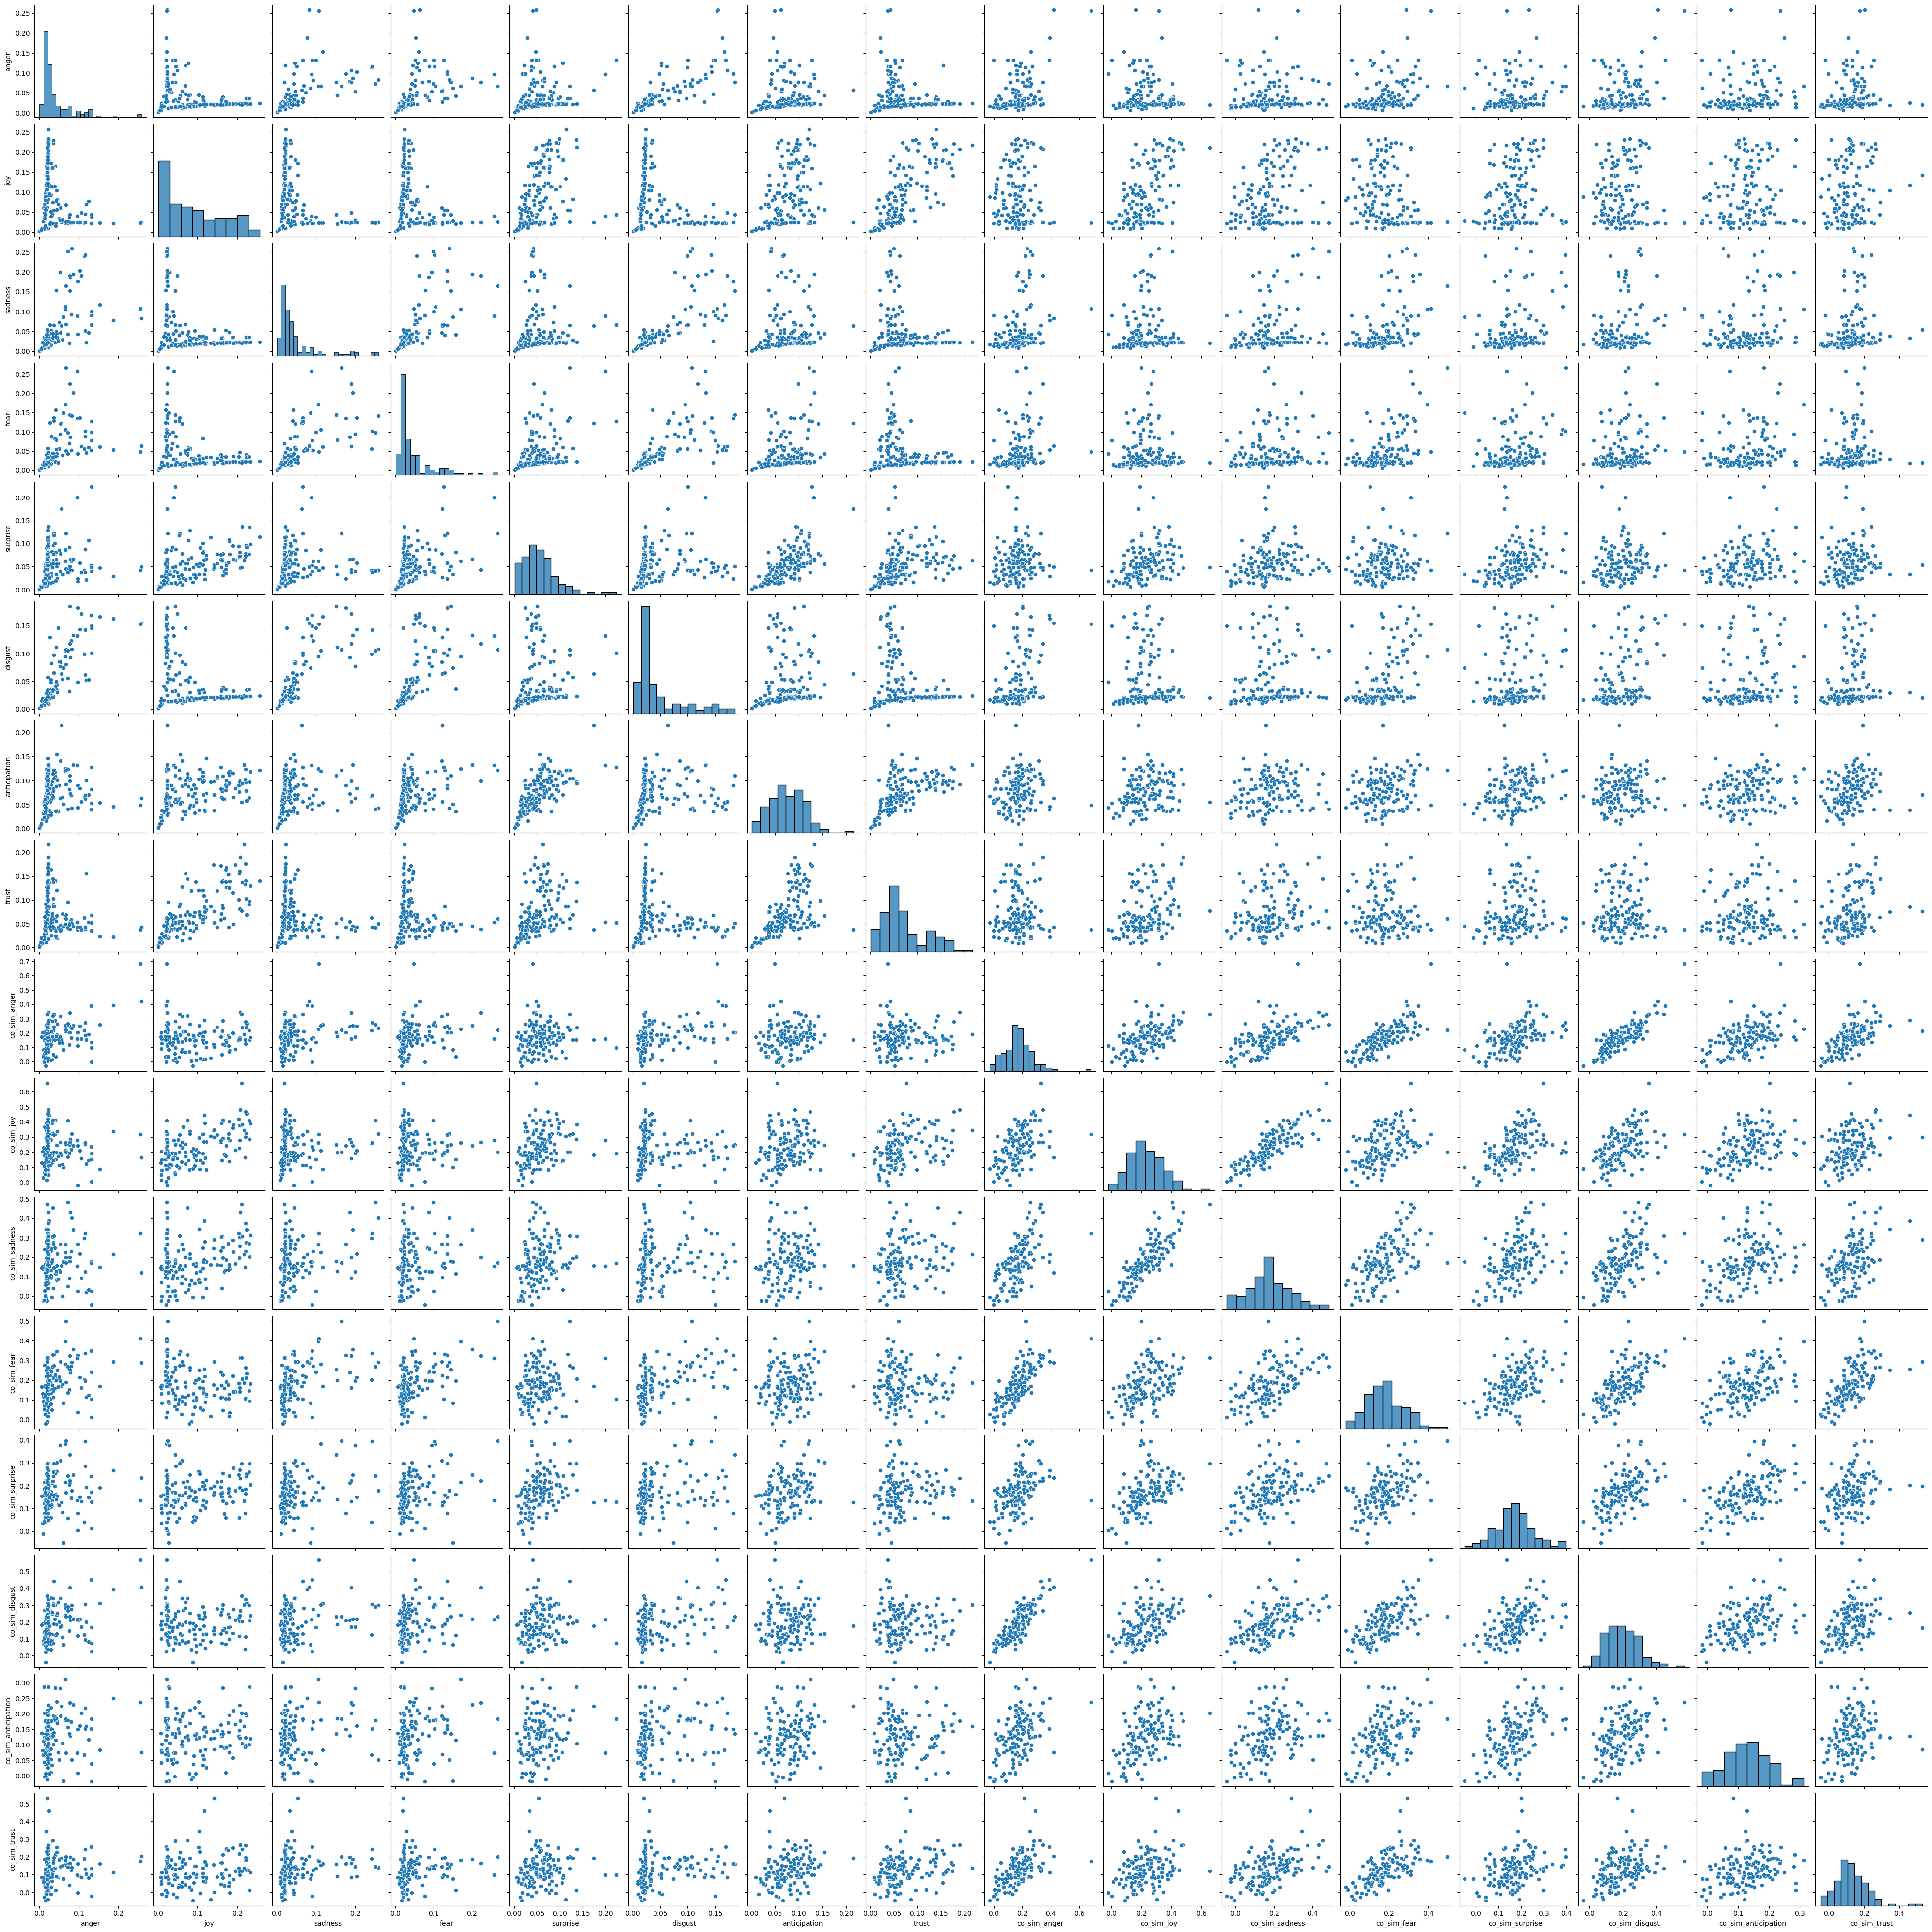

In [30]:
#Use pairplots to look for correlation between reported values by public and cosine similarities for the word vectors

#Define parameters to show on plot
cosin_eval = basic_emotions + cosine_sim_emotions

#Create plot
sns.pairplot(df_le01[cosin_eval])
#It is notable that the distribution of the basic emotion data has a skewed distribution

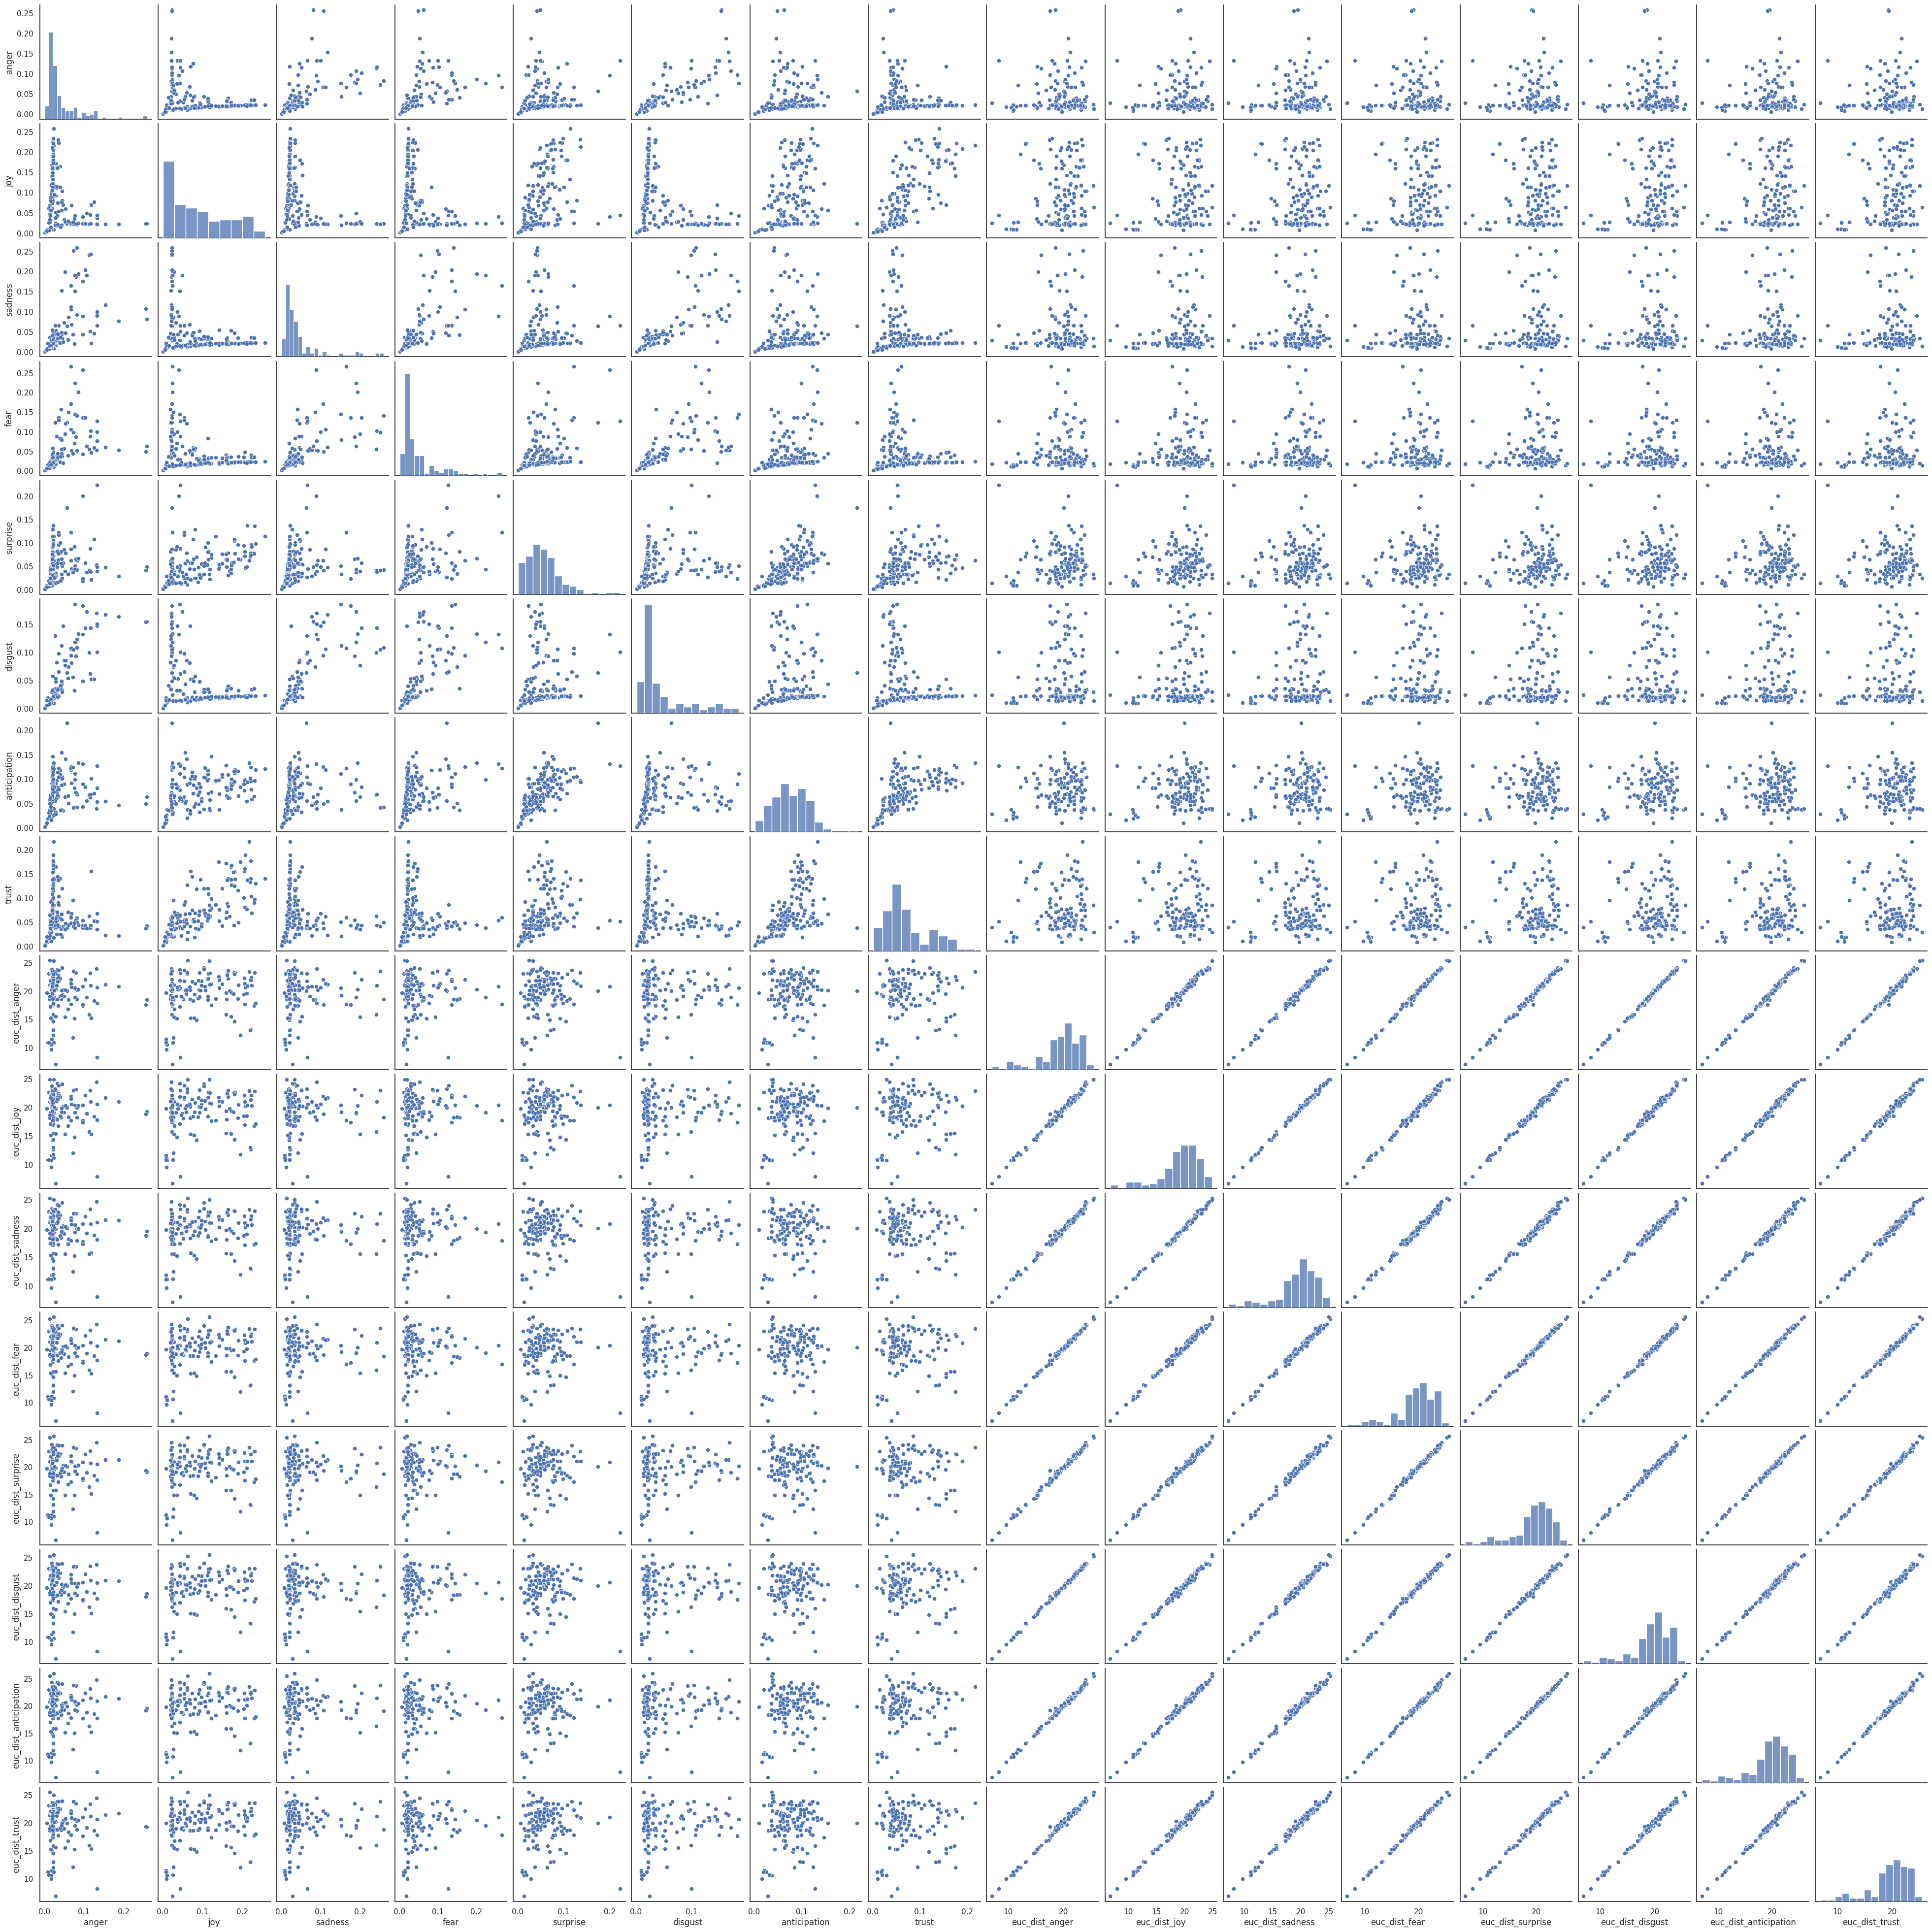

In [36]:
#Use pairplots to look for correlation (euclidian distances)

#Define parameters to show on plot
eucdist_eval = basic_emotions + euc_dist_emotions

#Create plot
sns.pairplot(df_le01[eucdist_eval])

The above pairplots in both cases show poor correlation between the similarity metrics and the reported basic emotion affinities. It is notable that in both cases the reported metrics have a more gaussian distribution than the reported metrics. Further work will be carried out to evaluate the potential usefullness of these metrics.

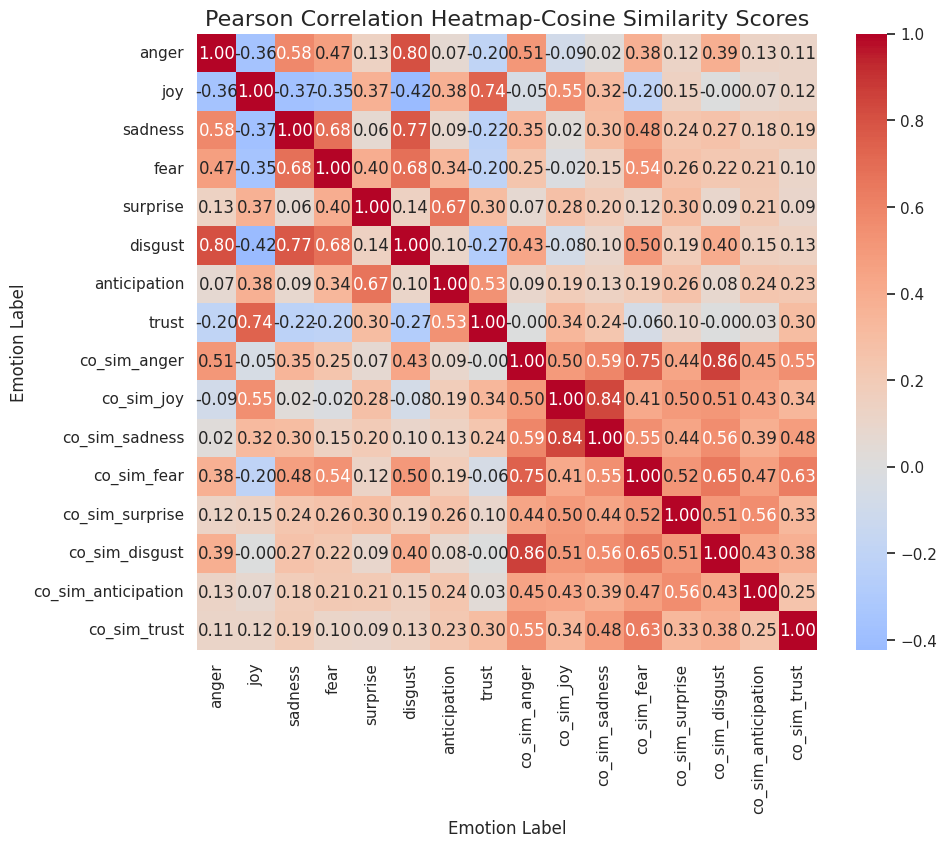

In [31]:
#Calculate Pearson correlation coefficients (cosine similarity scores)
correlation_matrix = df_le01[cosin_eval].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap-Cosine Similarity Scores", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

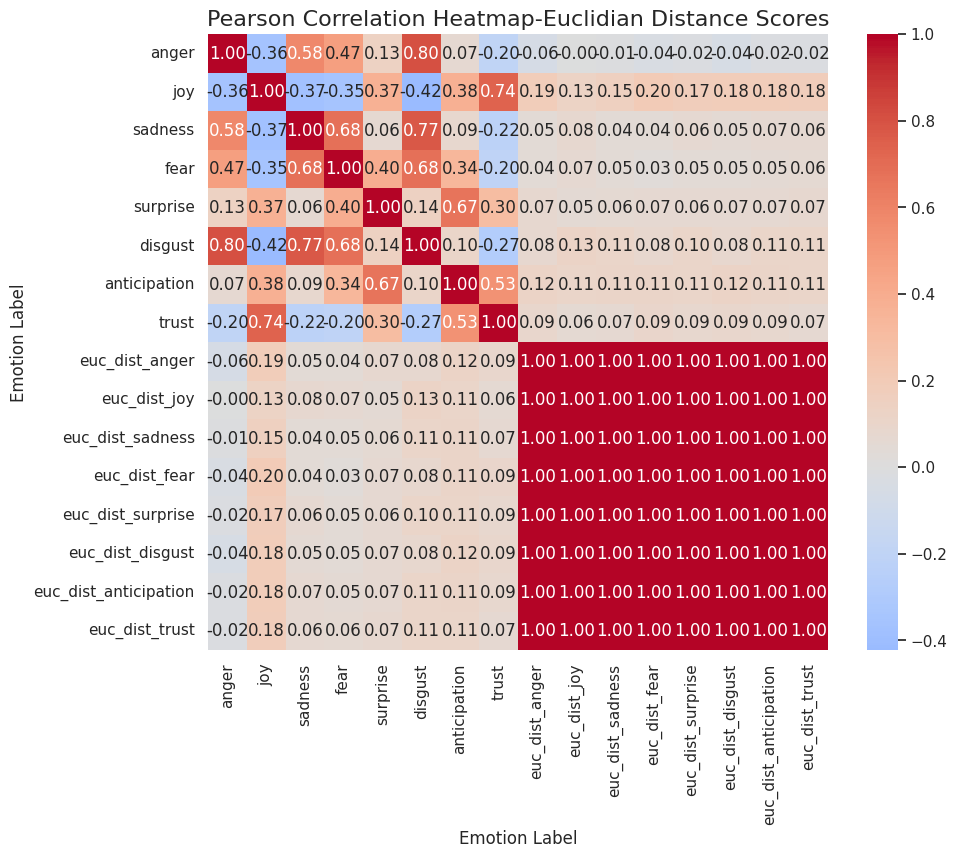

In [37]:
# Calculate Pearson correlation coefficients (euclidian distances)
correlation_matrix = df_le01[eucdist_eval].corr(method='pearson')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Pearson Correlation Heatmap-Euclidian Distance Scores", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

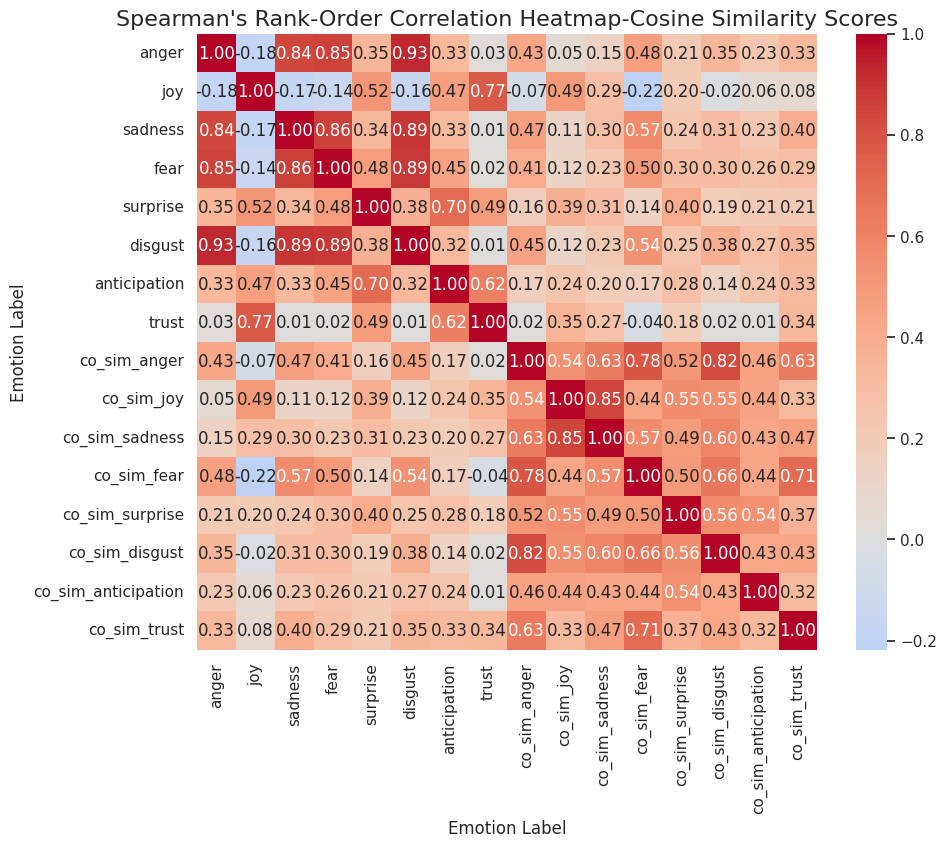

In [38]:
#Calculate Spearman correlation coefficients (cosine similarity scores)
correlation_matrix = df_le01[cosin_eval].corr(method='spearman')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Spearman's Rank-Order Correlation Heatmap-Cosine Similarity Scores", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

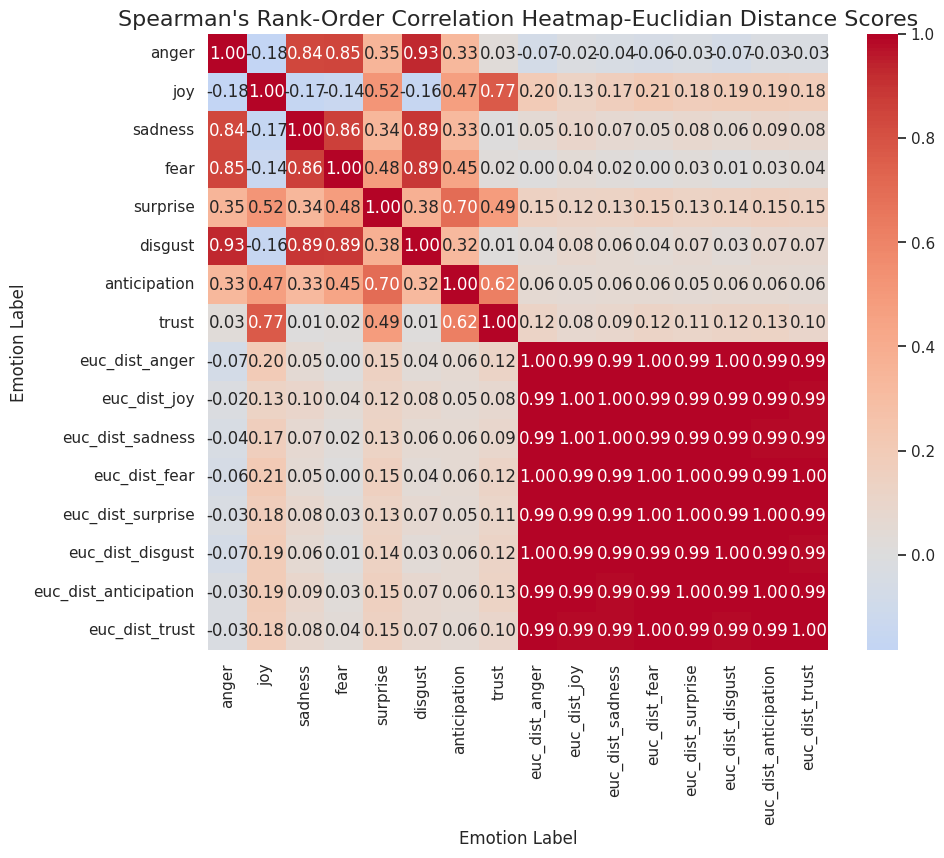

In [39]:
#Calculate Spearman correlation coefficients (euclidian distances)
correlation_matrix = df_le01[eucdist_eval].corr(method='spearman')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Spearman's Rank-Order Correlation Heatmap-Euclidian Distance Scores", fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

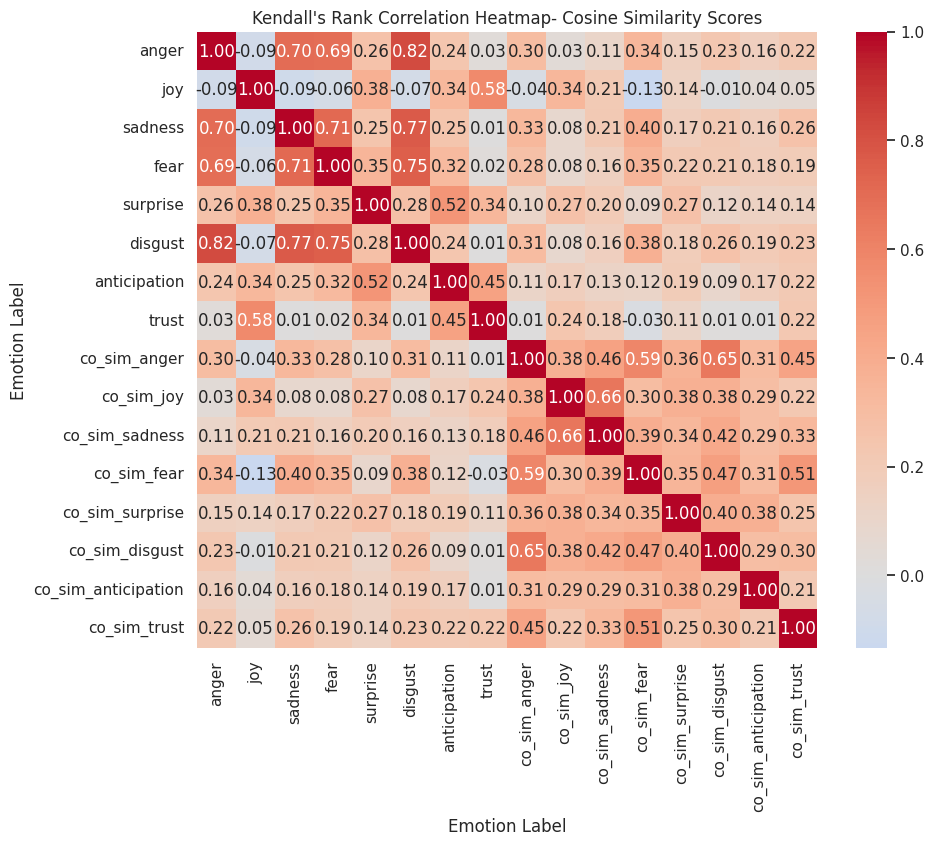

In [40]:
#Calculate Kendall's rank correlation coefficient (cosine similarity score)
correlation_matrix = df_le01[cosin_eval].corr(method='kendall')

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Kendall's Rank Correlation Heatmap- Cosine Similarity Scores")
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

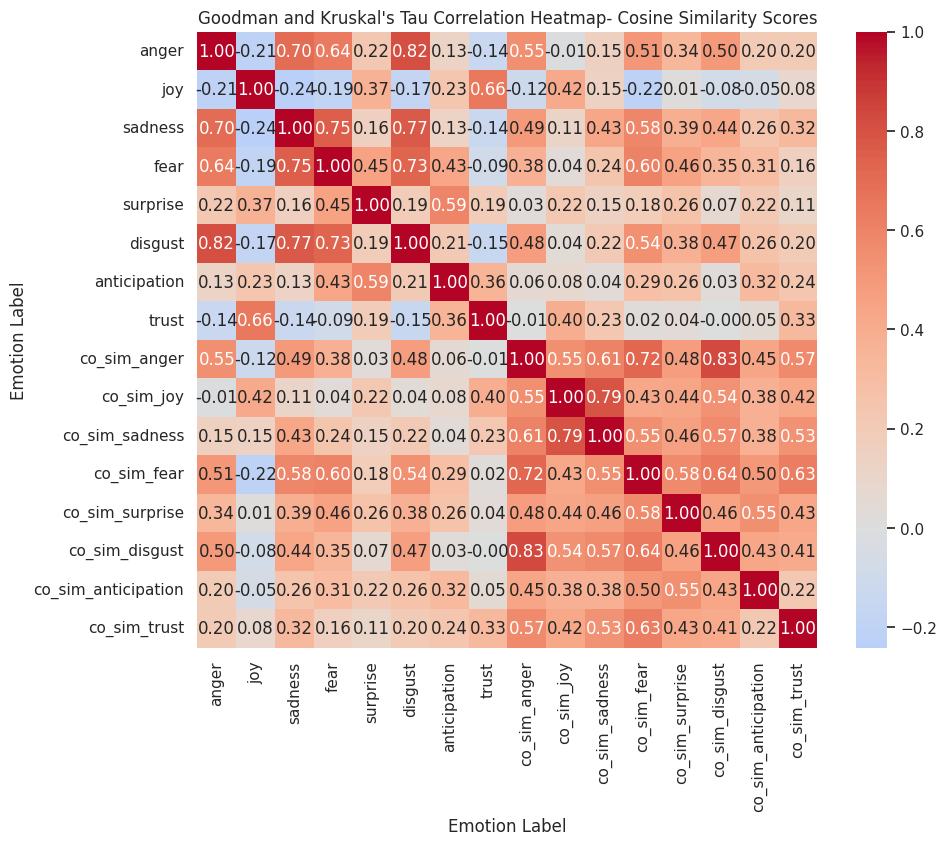

In [43]:
#Calculate Goodman and Kruskal's tau correlation coefficient (cosine similarity scores)
correlation_matrix = pd.DataFrame(index=cosin_eval, columns=cosin_eval, dtype=float)

for col1 in cosin_eval:
    for col2 in cosin_eval:
        tau, _ = weightedtau(df_le01[col1], df_le01[col2])
        correlation_matrix.loc[col1, col2] = tau

#Define heatmap design
sns.set(style='white')
plt.figure(figsize=(10, 8))

#Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")

#Add title and labels
plt.title("Goodman and Kruskal's Tau Correlation Heatmap- Cosine Similarity Scores")
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Emotion Label', fontsize=12)

#Show the plot
plt.show()

Heatmap based correlation plots highlighted some key findings. These values do significantly differ from the reported values in the dataset both in terms of scale and relative to each other. However, there is moderate correlation found in certain instances such as Spearmans rank heatmap to compare cosine similarity scores to reported values for each respective emotion. Additionally, it is clear that the correlation between 'negative' and 'positive' basic emotions with respect to one another is captured to some extent using the cosine similarity scores. The euclidian distance is not as effective in any case to capture trends in the reported data. This test shows that there may be some benefit to the addition of this data in later predictive models to improve outcomes.

In [33]:
#Remove columns containing eudlidian distance values from dataset
df_le01 = df_le01.drop(columns=['euc_dist_anger', 'euc_dist_joy', 'euc_dist_sadness',
                                'euc_dist_fear', 'euc_dist_surprise', 'euc_dist_disgust', 'euc_dist_anticipation',
                                'euc_dist_trust'])
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar primary_basic_emot  \
0  0.032855  0.065710  0.088298  ...    Positive                joy   
1  0.015419  0.024671  0.053967  ...    Positive       anticipation   
2  0.051856  0.028610  0.037551  ...    Positive                joy   
3  0.019122  0.040157  0.061191  ...    Positive                joy   
4  0.019370  0.067795  0.079417  ...    Positive                joy   

   co_sim_anger  co_sim_joy  co_sim_sadness  co_sim_fear co_sim_surprise  \
0      0.212815    0.398045        0.307879     0.170043        0.168778   
1      0.031860    0.097309        0.137938     0.102546        0.056646   
2      0.112067    0.165191        0.168149     0.186228        0.173427   
3      0.115099    0.183506        0.124933     0.159108        0.077226   
4      0.100389    0.269118        0.175544     0.122721        0.223669   

  co_sim_disgust co_sim_anticipation co_sim_trust  
0       0.276684            0.141978     0.103585  
1       0.071432            0.176522     0.040214  
2       0.126981            0.219476     0.101377  
3       0.162806            0.089916     0.037725  
4       0.129766            0.143079     0.081530  

[5 rows x 29 columns]

As these values will be used during ML, they will be scaled according to the previous method implemented and justified for the basic theory emotion data.

In [44]:
#Scale all data for basic emotions

#Re-Create a column that contains the sum of all basic emotion values
df_le01['total_prescale'] = df_le01['co_sim_anger'] + df_le01['co_sim_anticipation'] + df_le01['co_sim_disgust'] + df_le01['co_sim_fear'] + df_le01['co_sim_joy'] + df_le01['co_sim_sadness'] + df_le01['co_sim_surprise'] + df_le01['co_sim_trust']

#Repeat previous line to make column to facilitate scaling
df_le01['total'] = df_le01['total_prescale']

#Scale total column
scale_cols = ['total']

#Define function for scaling
def scaling(df_le01):
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    df_le01[scale_cols] = scaler.fit_transform(df_le01[scale_cols])
    return df_le01
df_le01 = scaling(df_le01)

#Determine scaling factor for the row
df_le01['scaling_factor'] = df_le01['total_prescale']/df_le01['total']

#Scale each basic emotion value using the scaling factor
df_le01['co_sim_anger'] = df_le01['co_sim_anger']/df_le01['scaling_factor']
df_le01['co_sim_anticipation'] = df_le01['co_sim_anticipation']/df_le01['scaling_factor']
df_le01['co_sim_disgust'] = df_le01['co_sim_disgust']/df_le01['scaling_factor']
df_le01['co_sim_fear'] = df_le01['co_sim_fear']/df_le01['scaling_factor']
df_le01['co_sim_joy'] = df_le01['co_sim_joy']/df_le01['scaling_factor']
df_le01['co_sim_sadness'] = df_le01['co_sim_sadness']/df_le01['scaling_factor']
df_le01['co_sim_surprise'] = df_le01['co_sim_surprise']/df_le01['scaling_factor']
df_le01['co_sim_trust'] = df_le01['co_sim_trust']/df_le01['scaling_factor']

df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  euc_dist_joy euc_dist_sadness  \
0  0.032855  0.065710  0.088298  ...     22.385473        22.605833   
1  0.015419  0.024671  0.053967  ...     21.534067        21.413471   
2  0.051856  0.028610  0.037551  ...     23.067062        23.046669   
3  0.019122  0.040157  0.061191  ...     19.776051        19.974701   
4  0.019370  0.067795  0.079417  ...     20.669111        20.956097   

   euc_dist_fear  euc_dist_surprise  euc_dist_disgust  euc_dist_anticipation  \
0      23.134501          23.141672         22.784658              23.209110   
1      21.503735          21.619774         21.609434              21.309780   
2      23.032419          23.070414         23.186100              22.946081   
3      19.860977          20.072878         19.841698              20.042284   
4      21.124264          20.863853         21.106775              21.071026   

  euc_dist_trust total_prescale     total scaling_factor  
0      23.310059       1.779807  0.631700       2.817488  
1      21.671391       0.714467  0.265697       2.689028  
2      23.256742       1.252896  0.450677       2.780031  
3      20.184591       0.950319  0.346725       2.740842  
4      21.234791       1.245816  0.448245       2.779322  

[5 rows x 40 columns]

In [45]:
#Remove other extraneous columns
df_le01 = df_le01.drop(columns=['total', 'total_prescale', 'scaling_factor'])
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  co_sim_anticipation co_sim_trust  \
0  0.032855  0.065710  0.088298  ...             0.050392     0.036765   
1  0.015419  0.024671  0.053967  ...             0.065645     0.014955   
2  0.051856  0.028610  0.037551  ...             0.078947     0.036466   
3  0.019122  0.040157  0.061191  ...             0.032806     0.013764   
4  0.019370  0.067795  0.079417  ...             0.051480     0.029334   

   euc_dist_anger  euc_dist_joy  euc_dist_sadness  euc_dist_fear  \
0       22.965086     22.385473         22.605833      23.134501   
1       21.752522     21.534067         21.413471      21.503735   
2       23.236128     23.067062         23.046669      23.032419   
3       19.995880     19.776051         19.974701      19.860977   
4       21.206022     20.669111         20.956097      21.124264   

  euc_dist_surprise euc_dist_disgust euc_dist_anticipation euc_dist_trust  
0         23.141672        22.784658             23.209110      23.310059  
1         21.619774        21.609434             21.309780      21.671391  
2         23.070414        23.186100             22.946081      23.256742  
3         20.072878        19.841698             20.042284      20.184591  
4         20.863853        21.106775             21.071026      21.234791  

[5 rows x 37 columns]

# Preparation of data for machine learning- Encoding unicode block and other text variables

EDA has highlighted that within certain unicode blocks, specific characterisics are more or less common, therefore this infomation may aid in predictive models and thus this information must be encoded so it can be considered during machine learning. The nature of unicode block categories is that they have no inherent order (it is a nominal variable) therefore this must be reflected in the encoding method selected. One-Hot encoding is therefore an appropriate method to achieve this.

However this may not necessarily be an ideal method for such work as this significantly increases the dimensionality of the data and thus the use of this data may be revised depending on the relative effects of increased dimensionality compared to the information contained in the original column.

In [46]:
# Perform one-hot encoding on nominal variables
df_le01 = pd.get_dummies(df_le01, columns=['Unicode block', 'sent_score_class', 'upper_error_class', 'lower_error_class', 'sent_polar', 'primary_basic_emot'])

df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar_Negative  \
0  0.032855  0.065710  0.088298  ...                    0   
1  0.015419  0.024671  0.053967  ...                    0   
2  0.051856  0.028610  0.037551  ...                    0   
3  0.019122  0.040157  0.061191  ...                    0   
4  0.019370  0.067795  0.079417  ...                    0   

   sent_polar_Positive  primary_basic_emot_anger  \
0                    1                         0   
1                    1                         0   
2                    1                         0   
3                    1                         0   
4                    1                         0   

   primary_basic_emot_anticipation  primary_basic_emot_disgust  \
0                                0                           0   
1                                1                           0   
2                                0                           0   
3                                0                           0   
4                                0                           0   

   primary_basic_emot_fear  primary_basic_emot_joy  \
0                        0                       1   
1                        0                       0   
2                        0                       1   
3                        0                       1   
4                        0                       1   

   primary_basic_emot_sadness  primary_basic_emot_surprise  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   primary_basic_emot_trust  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  

[5 rows x 57 columns]

In [47]:
#Verify transformation worked
df_le01.columns.values.tolist()

['unicode',
 'emoji',
 'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust',
 'Position',
 'le_+',
 'le_-',
 'le_0',
 'sent_score',
 'co_sim_anger',
 'co_sim_joy',
 'co_sim_sadness',
 'co_sim_fear',
 'co_sim_surprise',
 'co_sim_disgust',
 'co_sim_anticipation',
 'co_sim_trust',
 'euc_dist_anger',
 'euc_dist_joy',
 'euc_dist_sadness',
 'euc_dist_fear',
 'euc_dist_surprise',
 'euc_dist_disgust',
 'euc_dist_anticipation',
 'euc_dist_trust',
 'Unicode block_Arrows',
 'Unicode block_Dingbats',
 'Unicode block_Emoticons',
 'Unicode block_Geometric Shapes',
 'Unicode block_Miscellaneous Symbols',
 'Unicode block_Miscellaneous Symbols and Arrows',
 'Unicode block_Miscellaneous Symbols and Pictographs',
 'sent_score_class_Negative',
 'sent_score_class_Neutral',
 'sent_score_class_Positive',
 'upper_error_class_Negative',
 'upper_error_class_Neutral',
 'upper_error_class_Positive',
 'lower_error_class_Negative',
 'lower_error_class_Neutral',
 'lower_error_clas

# Preparation for machine learning- Null values

In [48]:
#Check for null values
df_le01.isnull().sum()

unicode                                                 0
emoji                                                   0
anger                                                   0
anticipation                                            0
disgust                                                 0
fear                                                    0
joy                                                     0
sadness                                                 0
surprise                                                0
trust                                                   0
Position                                                0
le_+                                                    0
le_-                                                    0
le_0                                                    0
sent_score                                              0
co_sim_anger                                           17
co_sim_joy                                             17
co_sim_sadness

In [49]:
#Drop columns with null values for the purposes of the testing
df_le01.dropna(inplace=True)
df_le01.isnull().sum()

unicode                                                0
emoji                                                  0
anger                                                  0
anticipation                                           0
disgust                                                0
fear                                                   0
joy                                                    0
sadness                                                0
surprise                                               0
trust                                                  0
Position                                               0
le_+                                                   0
le_-                                                   0
le_0                                                   0
sent_score                                             0
co_sim_anger                                           0
co_sim_joy                                             0
co_sim_sadness                 

# Initial Evaluation of Basic Prediction Models

Given that when this algorithm is to be implemented there will be no data pertaining to other basic emotions available, it is important to only include parameters external to the basic emotion data as these will be available for the real predictions. The following tests will initially be used to evaluate performance predicting anger. If initial results show promise then further work can be carried out using other algorithms.

This first test contains almost all parameters in the dataset. This is a very large number of dimensions and I do not expect the outcome to be optimal. Reduction in dimensionality will be performed later on to improve outcomes.

In [50]:
#Splitting data into train and test
X = df_le01.drop(columns=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'unicode', 'emoji'])
Y = df_le01['anger']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [51]:
#Importing libraries
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

In [52]:
#Create a function to evaluate the regressor and its parameters
def evaluate(reg_cls, params=None):
    reg=reg_cls()
    if params:
        reg=GridSearchCV(reg, param_grid=params, refit=True)
    reg.fit(X_train, Y_train)
    pred=reg.predict(X_test)

    if params:
        print(reg.best_params_)
        reg=reg.best_estimator_
    print('Mean Absolute Error:', mae(Y_test, pred), 'Mean Squared Error:', mean_squared_error(Y_test, pred),
          'R-squared score:', r2_score(Y_test, pred))

    #Calculate the percentage error
    percentage_error = abs(pred - Y_test) / Y_test

    #Count the number of correct predictions within 10% of the actual values
    correct_predictions = sum(percentage_error <= 0.1)

    #Calculate the percentage of correct predictions
    percentage_correct = correct_predictions / len(Y_test) * 100

    print('Percentage of Correct Predictions (within 10%):', percentage_correct, '%')

    return reg, pred

In [53]:
#Apply the function to the models
lr_reg,pred_lr = evaluate(LinearRegression)
rg_reg,pred_rg = evaluate(Ridge)
ls_reg,pred_ls = evaluate(Lasso)
rf_reg,pred_rf = evaluate(RandomForestRegressor)
gb_reg,pred_gb = evaluate(GradientBoostingRegressor)
xg_reg,pred_xg = evaluate(XGBRegressor)
lg_reg,pred_lg = evaluate(LGBMRegressor)

#Define parameters
params={"n_estimators":[100*i for i in range(1, 6)]}

Mean Absolute Error: 0.025400006918706093 Mean Squared Error: 0.001438251899501559 R-squared score: 0.5016397509748147
Percentage of Correct Predictions (within 10%): 22.22222222222222 %
Mean Absolute Error: 0.023737061615935553 Mean Squared Error: 0.0012648286000514484 R-squared score: 0.5617316435915938
Percentage of Correct Predictions (within 10%): 22.22222222222222 %
Mean Absolute Error: 0.03613920272838012 Mean Squared Error: 0.0029867825229544765 R-squared score: -0.03493253333405444
Percentage of Correct Predictions (within 10%): 3.7037037037037033 %
Mean Absolute Error: 0.026139695975597114 Mean Squared Error: 0.0014829331071288627 R-squared score: 0.48615752719495653
Percentage of Correct Predictions (within 10%): 7.4074074074074066 %
Mean Absolute Error: 0.02330919241828294 Mean Squared Error: 0.0013138604345762407 R-squared score: 0.5447419095454191
Percentage of Correct Predictions (within 10%): 18.51851851851852 %
Mean Absolute Error: 0.024796492658964945 Mean Squared Err

There are really poor outcomes here. This is likely due to the extremely high dimensionality of the data. The next step will be to reduce dimensionality and try again.

In [54]:
#Redefine X with fewer parameters
#Splitting data into train and test
X = df_le01[['Position', 'le_+', 'le_-', 'le_0', 'sent_score', 'co_sim_anger', 'co_sim_joy', 'co_sim_sadness',
             'co_sim_fear', 'co_sim_surprise', 'co_sim_disgust', 'co_sim_anticipation', 'co_sim_trust']]
Y = df_le01['anger']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [55]:
#Apply the above function onto the models
lr_reg,pred_lr = evaluate(LinearRegression)
rg_reg,pred_rg = evaluate(Ridge)
ls_reg,pred_ls = evaluate(Lasso)
rf_reg,pred_rf = evaluate(RandomForestRegressor)
gb_reg,pred_gb = evaluate(GradientBoostingRegressor)
xg_reg,pred_xg = evaluate(XGBRegressor)
lg_reg,pred_lg = evaluate(LGBMRegressor)

#Define parameters
params={"n_estimators":[100*i for i in range(1, 6)]}

Mean Absolute Error: 0.01727765761426144 Mean Squared Error: 0.0005015268181156199 R-squared score: 0.7415183007759394
Percentage of Correct Predictions (within 10%): 22.22222222222222 %
Mean Absolute Error: 0.018752787452383266 Mean Squared Error: 0.0007552914483412736 R-squared score: 0.6107306530283154
Percentage of Correct Predictions (within 10%): 18.51851851851852 %
Mean Absolute Error: 0.03312143638245074 Mean Squared Error: 0.0019456836201386606 R-squared score: -0.0027850757323224506
Percentage of Correct Predictions (within 10%): 0.0 %
Mean Absolute Error: 0.020082859925153945 Mean Squared Error: 0.0009989504125790753 R-squared score: 0.48515136029178596
Percentage of Correct Predictions (within 10%): 11.11111111111111 %
Mean Absolute Error: 0.026540078015059795 Mean Squared Error: 0.0015332066539499362 R-squared score: 0.20980125716177944
Percentage of Correct Predictions (within 10%): 11.11111111111111 %
Mean Absolute Error: 0.022850324237551307 Mean Squared Error: 0.001246

In [56]:
#Create a function to evaluate the outcomes in more detail
def evaluate_detail(reg_cls, params=None):
    reg=reg_cls()
    if params:
        reg=GridSearchCV(reg, param_grid=params, refit=True)
    reg.fit(X_train, Y_train)
    pred=reg.predict(X_test)

    if params:
        print(reg.best_params_)
        reg=reg.best_estimator_
    print('Mean Absolute Error:', mae(Y_test, pred)),
    print('Mean Squared Error:', mean_squared_error(Y_test, pred)),
    print('R-squared score:', r2_score(Y_test, pred))

    #Calculate the percentage error
    percentage_error = abs(pred - Y_test) / Y_test

    #Count the number of correct predictions within 2% of the actual values
    correct_predictions_2 = sum(percentage_error <= 0.02)
    percentage_correct_2 = correct_predictions_2 / len(Y_test) * 100
    print('Percentage of Correct Predictions (within 2%):', percentage_correct_2, '%')

    #Count the number of correct predictions within 5% of the actual values
    correct_predictions_5 = sum(percentage_error <= 0.05)
    percentage_correct_5 = correct_predictions_5 / len(Y_test) * 100
    print('Percentage of Correct Predictions (within 5%):', percentage_correct_5, '%')


    #Count the number of correct predictions within 10% of the actual values
    correct_predictions_10 = sum(percentage_error <= 0.1)
    percentage_correct_10 = correct_predictions_10 / len(Y_test) * 100
    print('Percentage of Correct Predictions (within 10%):', percentage_correct_10, '%')

    #Count the number of correct predictions within 20% of the actual values
    correct_predictions_20 = sum(percentage_error <= 0.2)
    percentage_correct_20 = correct_predictions_20 / len(Y_test) * 100
    print('Percentage of Correct Predictions (within 20%):', percentage_correct_20, '%')

    return reg, pred

In [57]:
#Look at XGBRegressor performance in more detail
xg_reg,pred_xg = evaluate_detail(XGBRegressor)
params={"n_estimators":[100*i for i in range(1, 6)]}

Mean Absolute Error: 0.022850324237551307
Mean Squared Error: 0.001246742886376602
R-squared score: 0.357441699773986
Percentage of Correct Predictions (within 2%): 7.4074074074074066 %
Percentage of Correct Predictions (within 5%): 7.4074074074074066 %
Percentage of Correct Predictions (within 10%): 14.814814814814813 %
Percentage of Correct Predictions (within 20%): 33.33333333333333 %


# Preparation to evaluate Neural Networks- Emoji Embeddings Dictionary

Neural networks are more complex models that can also potentially be used for prediction. They can capture more subtle relationships and patterns in the data and therefore may have improved outcomes for this purpose.

In [58]:
#Create an embedding dictionary
embeddings_dictionary = dict()

#Iterate through each row in the dataset
for index, row in df_le01.iterrows():
    emoji = row['emoji']

    #Check if the emoji exists in the KeyedVectors object
    if emoji in emoji2vec.key_to_index:
        vector_dimensions = emoji2vec.get_vector(emoji)
        embeddings_dictionary[emoji] = vector_dimensions

In [59]:
#Determine the number of unique emojis in the dataset at present
vocab_length = len(df_le01['emoji'].unique())
print(vocab_length)

132


In [60]:
#Create the embeddings matrix with all zeros
embedding_matrix = np.zeros((vocab_length, 300))
embedding_matrix.shape

(132, 300)

In [61]:
#Reset the DataFrame index
df_le01.reset_index(drop=True, inplace=True)

In [62]:
#Loop through each row to populate data for each unique emoji into the embedding
for i, row in df_le01.iterrows():
    emoji = row['emoji']
    if emoji in embeddings_dictionary:
        vector_dimensions = np.asarray(embeddings_dictionary[emoji], dtype="float32")
        embedding_matrix[i] = vector_dimensions

# Initial Evaluation of Neural Networks

In [63]:
#Importing libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding
from keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers import Reshape
from keras.layers import BatchNormalization, GlobalMaxPooling1D
from keras.regularizers import l1, l2

In [64]:
#Define a function to map the embedding from the dictionary onto the emoji, otherwise use an empty vector
def map_emoji_to_embedding(emoji):
    if emoji in embeddings_dictionary:
        return embeddings_dictionary[emoji]
    else:
        return np.zeros(300)

#Apply the function
df_le01['emoji_embedding'] = df_le01['emoji'].apply(map_emoji_to_embedding)
df_le01.head()

unicode emoji     anger  anticipation   disgust      fear       joy  \
0   1F308     🌈  0.020534      0.078030  0.020534  0.020534  0.162221   
1   1F319     🌙  0.015419      0.063219  0.015419  0.015419  0.053967   
2   1F31A     🌚  0.028610      0.032186  0.048279  0.028610  0.092982   
3   1F31E     🌞  0.019122      0.061191  0.019122  0.019122  0.168275   
4   1F31F     🌟  0.019370      0.073606  0.019370  0.019370  0.122031   

    sadness  surprise     trust  ...  sent_polar_Positive  \
0  0.032855  0.065710  0.088298  ...                    1   
1  0.015419  0.024671  0.053967  ...                    1   
2  0.051856  0.028610  0.037551  ...                    1   
3  0.019122  0.040157  0.061191  ...                    1   
4  0.019370  0.067795  0.079417  ...                    1   

   primary_basic_emot_anger  primary_basic_emot_anticipation  \
0                         0                                0   
1                         0                                1   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   primary_basic_emot_disgust  primary_basic_emot_fear  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   primary_basic_emot_joy  primary_basic_emot_sadness  \
0                       1                           0   
1                       0                           0   
2                       1                           0   
3                       1                           0   
4                       1                           0   

   primary_basic_emot_surprise  primary_basic_emot_trust  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

                                     emoji_embedding  
0  [-0.272291, 1.1176019, 1.4234279, 1.7466365, -...  
1  [-0.89786303, 1.9509411, -1.3655221, 1.5510684...  
2  [-0.07155819, 2.6526983, 0.9026799, 0.7054407,...  
3  [1.5490977, 1.5981269, 0.27876318, -0.60552436...  
4  [1.6323674, 1.010914, 2.2080367, 0.37723196, 1...  

[5 rows x 58 columns]

In [65]:
#Define input and target parameters
X = df_le01[['emoji_embedding', 'Position', 'le_+', 'le_-', 'le_0', 'sent_score', 'co_sim_anger', 'co_sim_joy', 'co_sim_sadness',
             'co_sim_fear', 'co_sim_surprise', 'co_sim_disgust', 'co_sim_anticipation', 'co_sim_trust']]
Y = df_le01['anger']

#Convert emoji embeddings to numpy arrays
X = np.array(df_le01['emoji_embedding'].tolist())

#Split data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [66]:
#Define the custom evaluation metrics

#Within 2%
def accuracy_within_2_percent(y_true, y_pred):
    #Calculate the percentage difference between true and predicted values
    percentage_difference = tf.abs((y_true - y_pred) / y_true) * 100.0

    #Check if the percentage difference is within 5%
    within_2_percent = tf.less_equal(percentage_difference, 2.0)

    #Calculate the mean accuracy within 5%
    mean_accuracy_within_2_percent = tf.reduce_mean(tf.cast(within_2_percent, tf.float32))
    return mean_accuracy_within_2_percent

#Repeat for a % difference within 5%
def accuracy_within_5_percent(y_true, y_pred):
    percentage_difference = tf.abs((y_true - y_pred) / y_true) * 100.0
    within_5_percent = tf.less_equal(percentage_difference, 5.0)
    mean_accuracy_within_5_percent = tf.reduce_mean(tf.cast(within_5_percent, tf.float32))
    return mean_accuracy_within_5_percent

#Repeat for a % difference within 10%
def accuracy_within_10_percent(y_true, y_pred):
    percentage_difference = tf.abs((y_true - y_pred) / y_true) * 100.0
    within_10_percent = tf.less_equal(percentage_difference, 10.0)
    mean_accuracy_within_10_percent = tf.reduce_mean(tf.cast(within_10_percent, tf.float32))
    return mean_accuracy_within_10_percent

In [67]:
#Importing libraries
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [68]:
#Start with a basic feedforward neural network

#Create a feedforward neural network architecture
NN_model = Sequential()

#Input Layer
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

#Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

#The Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38528     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 203,393
Trainable params: 203,393
Non-trainable params: 0
_________________________________________________________________


In [69]:
#Create a checkpoint callback to save model weights during training
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
#Only if they are better than the previous optimal option
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1,
                             save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [70]:
#Train the model
history = NN_model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.2,
                       callbacks=callbacks_list)

Epoch 1/500
1/3 [=========>....................] - ETA: 3s - loss: 0.2372 - mean_absolute_error: 0.2372 - accuracy_within_5_percent: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.03041, saving model to Weights-001--0.03041.hdf5
3/3 [==============================] - 2s 189ms/step - loss: 0.1370 - mean_absolute_error: 0.1370 - accuracy_within_5_percent: 0.0646 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0489 - mean_absolute_error: 0.0489 - accuracy_within_5_percent: 0.0625
Epoch 2: val_loss improved from 0.03041 to 0.02494, saving model to Weights-002--0.02494.hdf5
3/3 [==============================] - 0s 55ms/step - loss: 0.0488 - mean_absolute_error: 0.0488 - accuracy_within_5_percent: 0.0208 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249 - val_accuracy_within_5_percent: 0.0000e+00
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.03

In [71]:
#Load weights file of the best model and recompile the model
weights_file = 'Weights-219--0.01308.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_2_percent,
                                                                        accuracy_within_5_percent, accuracy_within_10_percent])

In [72]:
#Evaluate the model on the test data
results = NN_model.evaluate(X_test, Y_test)

1/1 [==============================] - 1s 850ms/step - loss: 0.0230 - mean_absolute_error: 0.0230 - accuracy_within_2_percent: 0.0000e+00 - accuracy_within_5_percent: 0.0000e+00 - accuracy_within_10_percent: 0.0741


In [74]:
#Play around with hyperparams manually to try to improve results

#Start new NN
NN_model = Sequential()

#Input Layer
NN_model.add(Dense(64, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.015)))

#Hidden Layers
NN_model.add(Dense(16, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(8, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
#NN_model.add(Dropout(0.2))

#Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
NN_model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Train the model
history1 = NN_model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.25, callbacks=callbacks_list)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                19264     
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 20,449
Trainable params: 20,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/3 [=========>....................] -

In [75]:
#Load weights file of the best model and recompile the model
weights_file = 'Weights-480--0.02489.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_2_percent,
                                                                        accuracy_within_5_percent, accuracy_within_10_percent])

In [76]:
#Evaluate the model on the test data
results = NN_model.evaluate(X_test, Y_test)

1/1 [==============================] - 1s 681ms/step - loss: 0.0214 - mean_absolute_error: 0.0193 - accuracy_within_2_percent: 0.0000e+00 - accuracy_within_5_percent: 0.0000e+00 - accuracy_within_10_percent: 0.0741


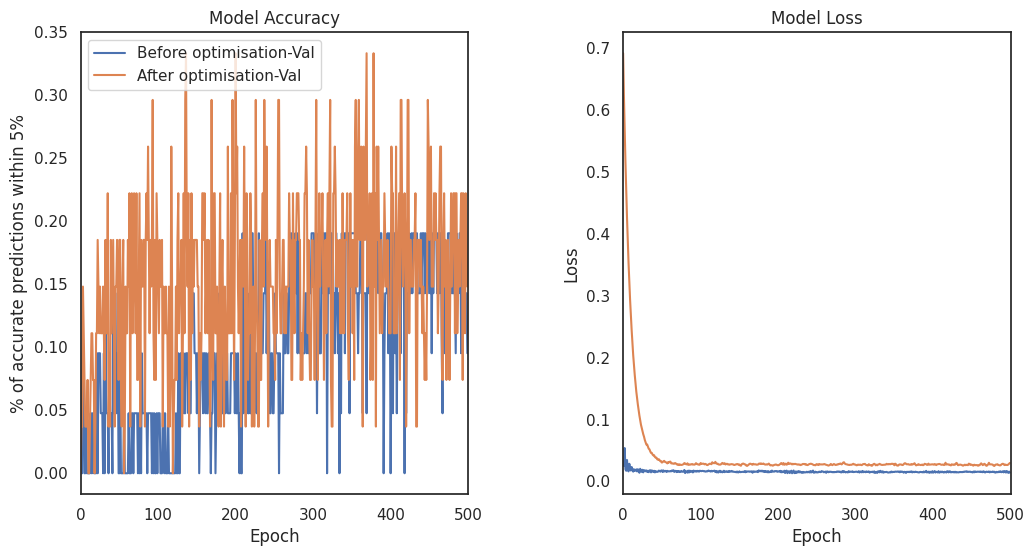

In [79]:
#Compare the two models performance over training duration using plots

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(history.history["val_accuracy_within_5_percent"], label="Before optimisation-Val")
axs[0].plot(history1.history["val_accuracy_within_5_percent"], label="After optimisation-Val")
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("% of accurate predictions within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 500)
axs[0].legend()

#Loss subplot
axs[1].plot(history.history["val_loss"], label="")
axs[1].plot(history1.history["val_loss"], label="")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 500)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

In [81]:
#Assess CNN impacts in the model and play with hyperparams

#Create the model
NN_model = Sequential()

#Input Layer (Reshape data to add a third dimension)
NN_model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

#Convolutional layers
NN_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
NN_model.add(MaxPooling1D(pool_size=2))

#Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(512, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

#Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
NN_model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

#Train the model
history3 = NN_model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.25, callbacks=callbacks_list)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 300, 1)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 298, 32)           128       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 dense_17 (Dense)            (None, 149, 256)          8448      
                                                                 
 batch_normalization_1 (Batc  (None, 149, 256)         1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 149, 256)         

In [ ]:
#Load weights file of the best model and recompile the model
weights_file = 'Weights-028--0.02776.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_2_percent,
                                                                        accuracy_within_5_percent, accuracy_within_10_percent])

In [ ]:
#Evaluate the model on the test data
results = NN_model.evaluate(X_test, Y_test)

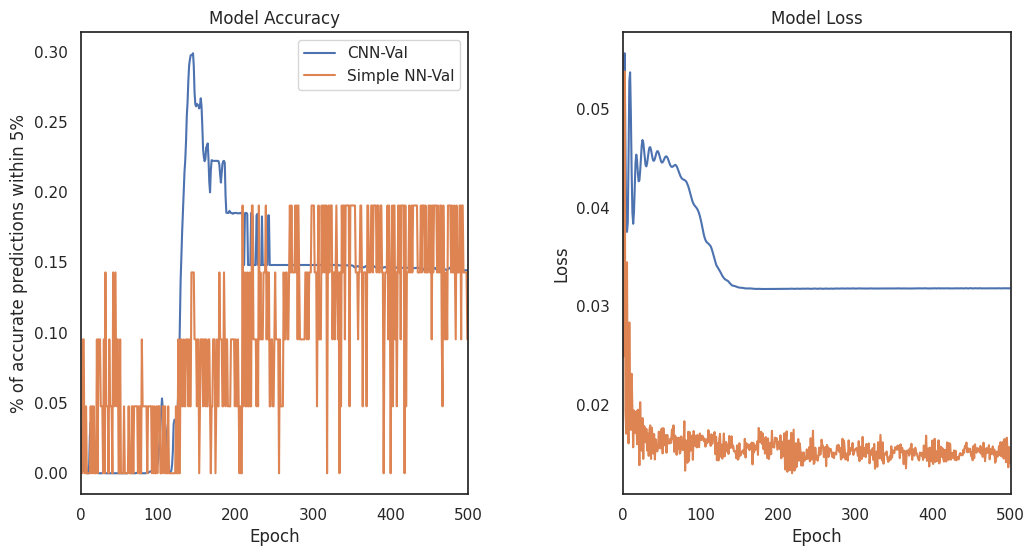

In [83]:
#Compare the CNN models performance against the feedforward NN over training duration using plots

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(history3.history["val_accuracy_within_5_percent"], label="CNN-Val")
axs[0].plot(history.history["val_accuracy_within_5_percent"], label="Simple NN-Val")
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("% of accurate predictions within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 500)
axs[0].legend()

#Loss subplot
axs[1].plot(history3.history["val_loss"], label="")
axs[1].plot(history.history["val_loss"], label="")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 500)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

In [84]:
#Play with outcomes using an LSTM layer

#Create the model
NN_model = Sequential()

#Input Layer (Reshape to add a third dimension)
NN_model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

NN_model.add(LSTM(64))

#Hidden Layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu', kernel_regularizer=l2(0.01)))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
NN_model.add(Dropout(0.2))

NN_model.add(Dense(512, kernel_initializer='normal', activation='relu'))
#NN_model.add(BatchNormalization())
#NN_model.add(Dropout(0.2))

#Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

#Compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_5_percent])
NN_model.summary()

#Create a checkpoint callback to save model weights
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

#Train the model
history4 = NN_model.fit(X_train, Y_train, epochs=500, batch_size=128, validation_split = 0.25, callbacks=callbacks_list)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 300, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense_21 (Dense)            (None, 256)               16640     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 512)              

In [ ]:
#Load weights file of the best model and recompile the model
weights_file = 'Weights-028--0.02776.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', accuracy_within_2_percent,
                                                                        accuracy_within_5_percent, accuracy_within_10_percent])

In [ ]:
#Evaluate the model on the test data
results = NN_model.evaluate(X_test, Y_test)

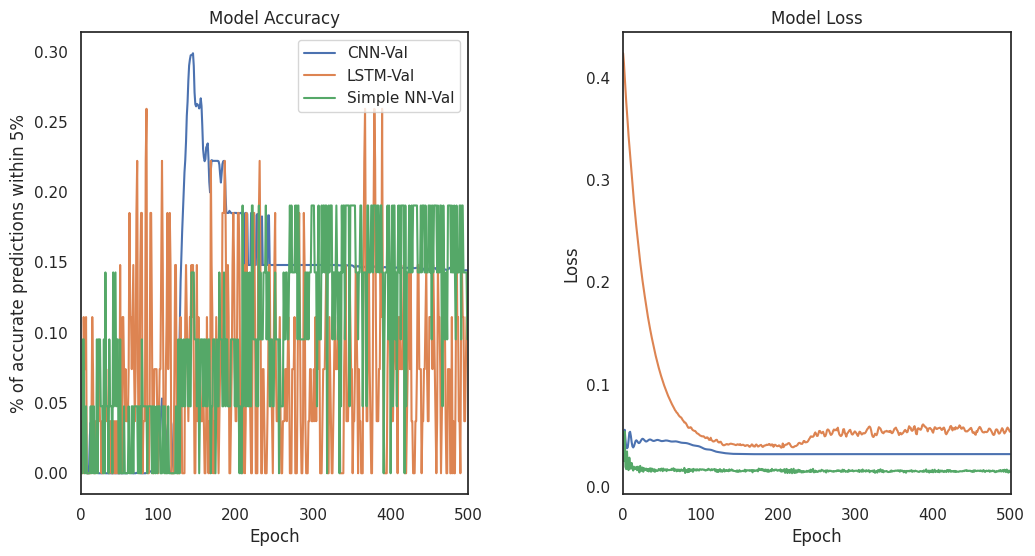

In [85]:
#Compare the CNN models performance against the feedforward NN over training duration using plots

#Define plot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Accuracy plot
axs[0].plot(history3.history["val_accuracy_within_5_percent"], label="CNN-Val")
axs[0].plot(history4.history["val_accuracy_within_5_percent"], label="LSTM-Val")
axs[0].plot(history.history["val_accuracy_within_5_percent"], label="Simple NN-Val")
axs[0].set_title("Model Accuracy")
axs[0].set_ylabel("% of accurate predictions within 5%")
axs[0].set_xlabel("Epoch")
axs[0].set_xlim(0, 500)
axs[0].legend()

#Loss subplot
axs[1].plot(history3.history["val_loss"], label="")
axs[1].plot(history4.history["val_loss"], label="")
axs[1].plot(history.history["val_loss"], label="")
axs[1].set_title("Model Loss")
axs[1].set_ylabel("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_xlim(0, 500)

#Adjust spacing
plt.subplots_adjust(wspace=0.4)

#Display plots
plt.show()

# Look at automated hyperparameter tuning for neural networks to improve performance

In [88]:
#Install libraries
#!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.5 MB/s eta 0:00:00


In [89]:
#Importing libraries
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold, ShuffleSplit
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
import time as time_module
import kerastuner as kt

In [94]:
#Start with a very basic option

#Define function for hyperparameter tuning
def build_model(hp):
    #Start model
    model = keras.Sequential()
    #Input layer (Reshape as before)
    model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
    #Hidden layers (Only one- vary the units to find the best outcome)
    model.add(layers.Dense(units=hp.Int('units',
                                       min_value=4,
                                       max_value=1028,
                                       step=64),
                          #Activation not varied in this case
                          activation='relu'))
    #Output layer
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    #Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            #Vary the learning rate to find optimal value
            hp.Choice('learning_rate',
                      values = [1e-2, 1e-3, 1e-4, 1e-5])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error', accuracy_within_5_percent])
    return model

In [95]:
#Define tuner to test models with varying parameters -5 trials
tuner = RandomSearch(build_model,
                    objective='mean_absolute_error',
                    max_trials=3,
                    executions_per_trial=1,
                    )

In [96]:
#Print search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 1028, 'step': 64, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [97]:
#Perform the random search
tuner.search(X_train, Y_train,
            epochs=250,
            validation_data=(X_test, Y_test)
            )

Trial 3 Complete [00h 00m 43s]
mean_absolute_error: 0.032961852848529816

Best mean_absolute_error So Far: 0.02656719647347927
Total elapsed time: 00h 04m 32s


In [98]:
#Print results summary
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="mean_absolute_error", direction="min")

Trial 1 summary
Hyperparameters:
units: 516
learning_rate: 0.0001
Score: 0.02656719647347927

Trial 0 summary
Hyperparameters:
units: 964
learning_rate: 0.001
Score: 0.026635820046067238

Trial 2 summary
Hyperparameters:
units: 4
learning_rate: 1e-05
Score: 0.032961852848529816


In [99]:
#Create a more complex function to assess more parameters

#Define function for hyperparameter tuning
def build_model(hp):
    #Start model
    model = keras.Sequential()
    #Input layer
    inp = tf.keras.layers.Input(shape=(X_train.shape[1],))
    #Test models with up to 6 dense layers
    num_dense = hp.Int('num_dense', min_value=1, max_value=6, step=1)
    #Iterate through each layer
    for i in range(num_dense):
        #Define units to test
        hp_units = hp.Int('units_{i}'.format(i=i), min_value=8, max_value=4096, step=128)
        #Define dropout values to test
        hp_drop_rate = hp.Choice('dp_{i}'.format(i=i), values=[0.0, 0.1, 0.15, 0.2, 0.25 ,0.3,
                                                               0.35,0.4, 0.5, 0.6, 0.7])
        #Define activation functions to test
        hp_activation = hp.Choice('dense_activation_{i}'.format(i=i),values=['relu', 'selu',
                                                                             'elu', 'swish'])
        #Define the way data flows through hidden layers
        x = tf.keras.layers.Dense(units=hp_units, activation=hp_activation)(inp)
        x = tf.keras.layers.Dropout(hp_drop_rate)(x)
        x = tf.keras.layers.BatchNormalization()(x)
    #Output layer
    outputs = tf.keras.layers.Dense(1, kernel_initializer='normal', activation='linear')(x)
    #Create the model with the defined input and outputs
    model = tf.keras.models.Model(inp, outputs)
    #Compile the model
    model.compile(
      optimizer=keras.optimizers.Adam(
        #Define learning rates to test
        hp.Choice('learning_rate', values = [1e-3, 1e-4, 1e-5, 0.0])),
      loss='mean_absolute_error',
      metrics=['mean_absolute_error', accuracy_within_5_percent])
    return model

In [100]:
#Define X and Y parameters
X = df_le01.drop(columns=['unicode', 'emoji', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
                          'sadness', 'surprise', 'trust'])
Y = df_le01['anger']

#Convert the emoji embedding to a numpy array
X = np.array(df_le01['emoji_embedding'].tolist())

#Check shape of data
X.shape, Y.shape

((132, 300), (132,))

In [ ]:
#Defining parameters
feats = np.arange(0,X.shape[1],1)
inp_size = int(np.ceil(1* len(feats)))
n_split = 5
n_repeats = 1
bests=[]
seeds = [0, 1]
n_round = len(seeds)
shuffle_split_size = 0.2

for seed in seeds:
    split_cols = np.random.choice(feats, inp_size, replace=False)
    #Use k fold cross validation to split data into train and test
    for n, (train, test) in enumerate(KFold(n_splits = n_split, random_state=0,
                                       shuffle = True).split(X, Y)):
        st = time_module.time()
        #Define tuning objectives and params
        tuner = kt.tuners.BayesianOptimization(build_model,
                     kt.Objective('val_accuracy_within_5_percent', direction="max"),
                     max_trials = 150, overwrite=True)
        start_time = time_module.time()
        X_train = X[train][:, split_cols]
        X_val = X[test][:, split_cols]
        Y_train, Y_val = Y[train], Y[test]
        #Early stop if the validation accuracy does not improve for 20 epochs
        callbacks=[EarlyStopping(monitor='val_accuracy_within_5_percent', mode='max', patience=20)]
        start_time = time_module.time()
        #Perform hyperparameter search using train and val data
        tuner.search(X_train, Y_train,validation_data=(X_val, Y_val),
                            epochs = 500, batch_size = 128,
                            verbose = 0, callbacks = callbacks)
        #Create method to recall best hyperparameters identified during the trial
        n_top = 5
        best_hps = tuner.get_best_hyperparameters(n_top)
        end_time = time_module.time()
        bests.append(best_hps)
        for i in range(n_top):
            print(best_hps[i].values)
        #Print statements to monitor the progress of the tests
        print('Seed', seed, 'Fold', n, 'Time elapsed:', "{:.2f}".format((end_time-start_time)/60), 'minutes')
        #Delete old tuner for memory conservation
        del tuner